## **Notebook Content**

Project: *Customer Prioritization Under Constraints*

File: 02_feature_engineering.ipynb <br>
Author: Bryan Melvida

Purpose:
- Translate cleaned transactional data into customer-level behavioral signals
- Encode timing, persistence, efficiency, and execution-relevant behavior
- Establish an interpretable feature set suitable for constrained prioritization and downstream segmentation

Input: [`customer_cleaned.parquet`](../data/cleaned/customer_cleaned.parquet) <br>

Output: [`customer_features.parquet`](../data/preprocessed/customer_features.parquet)<br>
Related Documentation: [`feature_definitions.md`](../docs/feature_engineering/feature_definitions.md) [`feature_rationale.md`](../docs/feature_engineering/feature_rationale.md)

<br>

---

<br>

In [1]:
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
from pathlib import Path

import sys
sys.path.append('../')
import src.assessment_views as av
from src import plot_settings

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

plot_settings.set()

In [ ]:
df = pd.read_parquet('../data/cleaned/customer_cleaned.parquet', engine= 'pyarrow')

# Instantiate customer features dataframe
customer_features = df[['CustomerID']].astype(int).drop_duplicates().reset_index(drop= True)

<br>

---

## **Population Scope Definition**

- One time buyers were excluded from the clustering population due to insufficient behavioral history to support reliable segmentation
- Including single transaction customers would introduce incomplete feature profiles and add noise to cluster structure without supporting differentiated action


In [3]:
tx_counts = df.groupby('CustomerID')['InvoiceDate'].count().reset_index(name='TxCount')
onetime_buyer = tx_counts.loc[tx_counts['TxCount']==1, :]

df_customer = df.loc[~df['CustomerID'].isin(onetime_buyer['CustomerID']), :].copy()
df_customer['CustomerID'] = df_customer['CustomerID'].astype(int)

min_tx_check = df_customer.groupby('CustomerID')['InvoiceDate'].count().min()
removed_customer = onetime_buyer['CustomerID'].nunique()

print(f'Customer Minimum Transaction: {min_tx_check}')
av.df_shape(df_customer)

Customer Minimum Transaction: 2
Total Rows: 313,096
Total Columns: 8


<br>

---

## **Feature Engineering**

Constructs customer-level behavioral features that focus on:
- Timing and persistence of engagement
- Efficiency and complexity of transactions
- Behavioral signals that justify differentiated treatment

**Cancellation Rate**
>Captures the degree of transaction reversal behavior, serving as a signal of execution friction, behavioral instability, and operational cost associated with serving the customer

In [4]:
total_tx = df_customer['CustomerID'].value_counts()
cancelled_tx = df_customer.loc[df_customer['InvoiceNo'].str.startswith('C'), :]

cancellation_count = (
    cancelled_tx['CustomerID']
    .value_counts()
    .reset_index(name= 'cancelled_tx')
    )

cancellation_count['total_tx'] = cancellation_count['CustomerID'].map(total_tx)
cancellation_count['cancellation_rate'] =  cancellation_count['cancelled_tx'] / cancellation_count['total_tx']

# Assign 0% cancellation rate for customers w/o cancelled transactions
customer_features['cancellation_rate'] = customer_features['CustomerID'].map(
    cancellation_count.set_index('CustomerID')['cancellation_rate']).fillna(0)

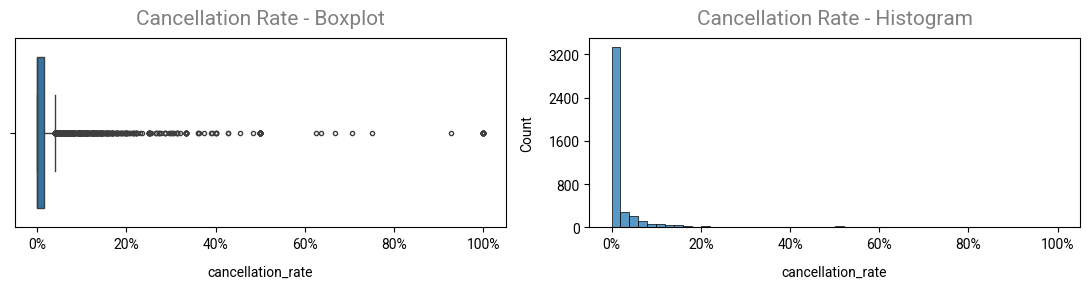

In [5]:
av.feature_distribution_view(data= customer_features,
                             column= 'cancellation_rate', 
                             titles= 'Cancellation Rate', 
                             format_percent= True
                             )
plt.show()

*Distribution check passed. No corrective action required*

<br>

**RFM Based Behavioral Features**

**`Days Since Last Purchase`** *( Timing )* <br>
>Indicates how recently a customer has engaged, supporting assessment of engagement recency and the expected relevance of near-term action
>

**`Total Transactions`** *( Persistence )*
>Represents the extent of repeated engagement, distinguishing sustained customer relationships from isolated or episodic interactions
>

**`Average Order Value`** *( Efficiency )*
>Reflects transaction-level efficiency, indicating whether higher-touch actions are justified relative to the typical scale of customer interaction
>

In [6]:
# Feature: Days Since last Purchase
rfm_features = df_customer.groupby('CustomerID')['InvoiceDate'].max().reset_index(name= 'last_purchase_date')

rfm_features['df_last_date'] = df_customer['InvoiceDate'].max()
rfm_features['days_since_last_purchase'] = (rfm_features['df_last_date'] - rfm_features['last_purchase_date']).dt.days

# Feature: Total Transaction
rfm_features['total_transaction'] = (df_customer.groupby('CustomerID')['InvoiceNo'].nunique()).values

# Feature: Average Order Value
df_customer['sales'] = df_customer['UnitPrice'] * df_customer['Quantity']
rfm_features['avg_order_value'] = (df_customer.groupby('CustomerID')['sales'].mean()).values


rfm_features.drop(columns= ['last_purchase_date', 'df_last_date'], inplace= True)
customer_features = pd.merge(customer_features, rfm_features, on= 'CustomerID')

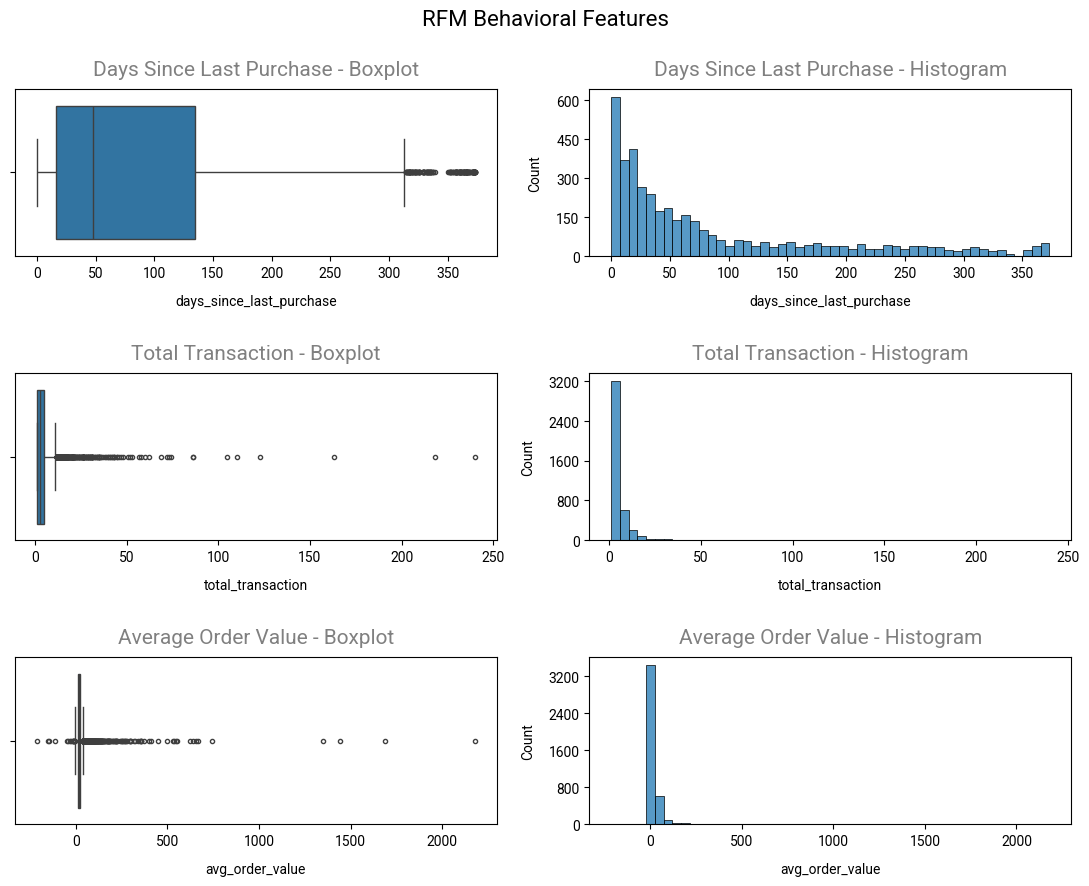

In [7]:
av.feature_distribution_view(data= customer_features,
                             column=['days_since_last_purchase', 'total_transaction', 'avg_order_value'],
                             titles=['Days Since Last Purchase', 'Total Transaction', 'Average Order Value'],
                             suptitle= 'RFM Behavioral Features'
                             )
plt.show()

*Distribution check passed. Observed negative values are associated with cancelled transactions*

<br>

**Purchase Behavior Features**

**`Average Days Between Purchases`**
>Measures purchasing cadence consistency, supporting differentiation between predictable engagement patterns and irregular or burst-driven behavior
>

**`Unique Count of Purchased Products`**
>Indicates product diversity, serving as a proxy for operational complexity and the potential need for differentiated handling
>

**`Product Repeat Rate`**
>Captures the tendency toward repeat purchasing versus exploratory behavior, informing the feasibility of standardized versus bespoke treatment
>


In [8]:
# Feature: Average Days Between Purchases
date_difference = df_customer.sort_values(['CustomerID', 'InvoiceDate'])
date_difference['date_diff'] = df_customer.groupby('CustomerID')['InvoiceDate'].diff().dt.days

purchase_behavior = date_difference.groupby('CustomerID')['date_diff'].mean().reset_index(name= 'avg_days_between_purchases')

# Feature: Unique Count of Purchased Product
purchase_behavior['n_unique_purchased_product'] = (df_customer.groupby('CustomerID')['StockCode'].nunique()).values

# Feature: Repeat Rate
purchase_behavior['unique_total_purchased'] = (df_customer.groupby('CustomerID')['StockCode'].count()).values

purchase_behavior['product_repeat_rate'] = (
    purchase_behavior['unique_total_purchased'] - purchase_behavior['n_unique_purchased_product']
    ) / purchase_behavior['unique_total_purchased']


purchase_behavior.drop(columns= 'unique_total_purchased', inplace= True)
customer_features = pd.merge(customer_features, purchase_behavior, on= 'CustomerID')

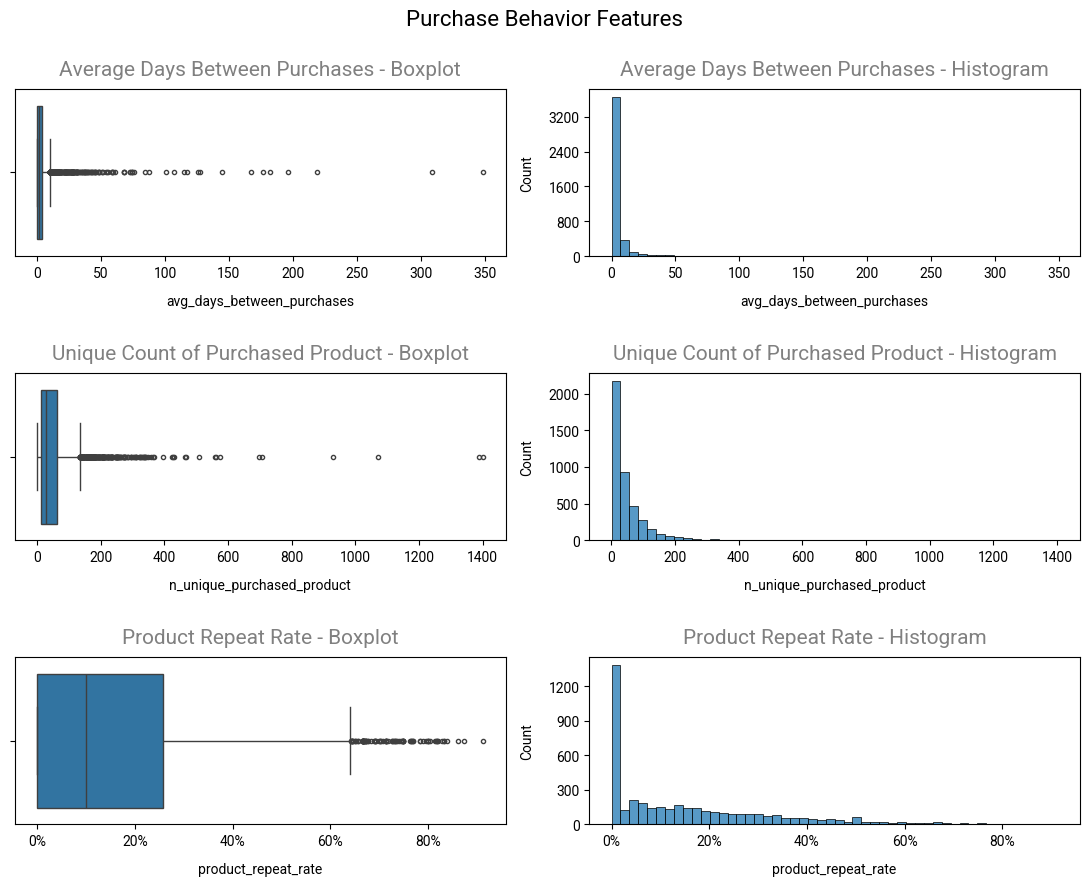

In [9]:
av.feature_distribution_view(
    data= customer_features,
    column= ['avg_days_between_purchases', 'n_unique_purchased_product', 'product_repeat_rate'],
    titles= ['Average Days Between Purchases', 'Unique Count of Purchased Product', 'Product Repeat Rate'],
    suptitle= 'Purchase Behavior Features',
    format_percent=[False, False, True]
    )
plt.show()

*Distribution check passed. No corrective action required*

<br>

**`Seasonal Shopper Indicator`**
>Identifies customers whose activity is concentrated within narrow time windows, signaling timing sensitivity and episodic execution requirements
>

In [10]:
df_customer['Month'] = df_customer['InvoiceDate'].dt.month

# Monthly total spend
monthly_spending = df_customer.groupby(['CustomerID', 'Month'])['sales'].sum().reset_index(name= 'monthly_spend')

seasonal_indicator = monthly_spending.groupby('CustomerID').agg(
    total_spend = ('monthly_spend', 'sum'),
    highest_monthly= ('monthly_spend', 'max')
    ).reset_index()

# Flag as Seasonal Shopper if 80% of annual spending occurs in highest spending month
seasonal_indicator['spend_ratio'] = (
    seasonal_indicator['highest_monthly']/ seasonal_indicator['total_spend']
    ).fillna(0)

seasonal_indicator['is_seasonal'] = np.where(seasonal_indicator['spend_ratio']>= 0.8, 1, 0)

customer_features['is_seasonal'] = customer_features['CustomerID'].map(
    seasonal_indicator.set_index('CustomerID')['is_seasonal'])


print(f"Seasonal Customers Count: {customer_features['is_seasonal'].sum()} "
      f"({customer_features['is_seasonal'].sum() / customer_features.shape[0] * 100 :.2f}%)")

Seasonal Customers Count: 1702 (40.03%)


<br>

**`United Kingdom Location Indicator`**
>Identifies whether a customer is based in the United Kingdom, enabling geographic segmentation and contextual interpretation of customer behavior across regions
>

In [11]:
# Collapse country records to customer level using most frequent location
location_info = df_customer.groupby(['CustomerID','Country']).size().groupby(level= 0).idxmax()
customer_location = location_info.apply(lambda x: x[1]).reset_index(name='Most_Frequent_Country')

customer_location['is_uk_customer'] = np.where(customer_location['Most_Frequent_Country'] == 'United Kingdom', 1, 0)

customer_features['is_uk_customer'] = customer_features['CustomerID'].map(customer_location.set_index('CustomerID')['is_uk_customer'])

print(f"United Kingdom based Costumer Count: {customer_features['is_uk_customer'].sum()} "
      f"({customer_features['is_uk_customer'].sum() / customer_features.shape[0] * 100 :.2f}%)")


United Kingdom based Costumer Count: 3834 (90.17%)


<br>

In [12]:
#Export engineered dataset
customer_features.to_parquet('../data/preprocessed/customer_features.parquet', engine= 'pyarrow', index= False)

<br>

---

## **End of Notebook**

* Customer level behavioral features have been constructed in line with the defined population scope and prioritization objective.
* Feature definitions and behavioral rationale are documented in: [`feature_definitions.md`](../docs/feature_engineering/feature_definitions.md) [`feature_rationale.md`](../docs/feature_engineering/feature_rationale.md)
* One time buyers have been explicitly excluded from segmentation feature generation, as documented in the *Population Scope Definition* section.
* The resulting feature set is designed to support interpretable behavioral segmentation for constrained execution contexts.
* Ready for downstream notebook: [`03_dimensional_reduction.ipynb`](../notebooks/03_dimensional_reduction.ipynb)